# Analyze A/B Test Results 

I have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [General Conclusion](#generalconclusion)

 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be applying A/B test and be working to understand the results of an A/B test run by an e-commerce website. Through this notebook, I will aim to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
random.seed(42)

### 1.1 Reading Dataset
Now, the `ab_data.csv` data is read and stored in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|





**a.** Lets read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** The cell below is used to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
((df.group == 'treatment') & (df.landing_page != 'new_page')).sum()+((df.group != 'treatment') & (df.landing_page == 'new_page')).sum()

3893

**f.** Checking if any of the rows have missing values.

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 1.2 Cleaning Dataset 
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  




**a.** Now we figure out how should we handle the rows where the group and landing_page columns don't match store this in a new dataset that meets the specifications.  we name the new dataframe **df2**.

In [8]:
# The inaccurate rows are removed, and the result is stored in a new dataframe df2
df2 = df.query('group == "control" & landing_page == "old_page"').append(df.query('group == "treatment" & landing_page == "new_page"'))


In [9]:
# Double checking all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3 Querying Dataset 

**a.** Unique **user_id**s in **df2**

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

**b.** There is one **user_id** repeated in **df2**. This can be found as the following:

In [12]:
df2[df2.user_id.duplicated() == True].user_id

2893    773192
Name: user_id, dtype: int64

**c.** The rows for the duplicate **user_id** are displayed. 

In [13]:
df2[df2.user_id.duplicated(keep = False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** **one** of the rows with a duplicate **user_id**, is removed from the **df2** dataframe.

In [14]:
# One of the rows with a duplicate user_id is removed.
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(index = 2893)
# Checking again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

### 1.4 Analyzing Dataset 

**a.** The probability of an individual converting regardless of the page they receive<br><br>





In [15]:
cr = (df2.converted == 1).mean()
cr

0.11959708724499628

**b.** Given that an individual was in the `control` group, the probability they converted:

In [16]:
cr_c = (df2.query('group == "control"').converted == 1).mean()
cr_c

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, the probability they converted:

In [17]:
cr_t = (df2.query('group == "treatment"').converted == 1).mean()
cr_t

0.11880806551510564

In [18]:
# The actual difference (obs_diff) between the conversion rates for the two groups is calculated.
obs_diff = cr_t - cr_c
obs_diff

-0.0015782389853555567

**d.** The probability that an individual received the new page:

In [19]:
(df2.landing_page == "new_page").mean()

0.50006194422266881

**e.** Considering the results from parts (a) through (d) above, from the conversion rates of both control and treatment groups, it is noticed that control group converted rate is higher than that for treatment group. Therefore, the control group users lead to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1 Hypothesis Testing
For now, we consider the need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (1.4.c). 

We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, then our null and alternative hypotheses (**$H_0$** and **$H_1$** ) should be:


>$$H_0: p_{new} - p_{old} \leq 0$$
>
>
>$$H_1: p_{new} - p_{old} > 0$$
>
>
>**$p_{new}$ and $p_{old}$ are the coversion rates for treatment and control groups, respectivley.**

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, it is assumed that $p_{new}$ and $p_{old}$ are equal. Furthermore, it is assumed that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



The cells below are used to provide the necessary parts of this simulation.

**a.** The **conversion rate** for $p_{new}$ under the null hypothesis: 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** The **conversion rate** for $p_{old}$ under the null hypothesis:

In [21]:
p_old = p_new
p_old

0.11959708724499628

**c.** The number of individuals in the treatment group, $n_{new}$: <br><br>
*Hint*: The treatment group users are shown the new page.

In [22]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

**d.** The number of individuals in the control group, $n_{old}$:

In [23]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

**e. Simulating Sample for the `treatment` Group**<br> 
Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: `numpy.random.choice()` method is used to randomly generate $n_{new}$ number of values. <br>
These $n_{new}$ 1's and 0's are stored in the `new_page_converted` numpy array.


In [24]:
# Simulating a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size = n_new, p = [1-p_new , p_new])

new_page_converted.mean()

0.1201913151193999

**f. Simulating Sample for the `control` Group** <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> These $n_{old}$ 1's and 0's are stored in the `old_page_converted` numpy array.

In [25]:
# Simulating a Sample for the control Group
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old , p_old])

old_page_converted.mean()

0.11902336274901221

**g.** Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for the simulated samples from the parts (e) and (f) above. 

In [26]:
diff_rate = new_page_converted.mean() - old_page_converted.mean()
diff_rate

0.0011679523703876926


**h. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [27]:
# Sampling distribution
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plotting a histogram of the **p_diffs**.<br><br>
Also, using `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


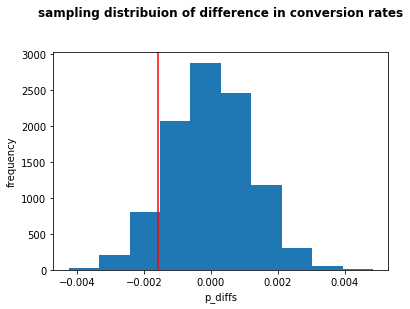

In [28]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color = 'r');
plt.xlabel('p_diffs')
plt.ylabel('frequency')
  
plt.title('sampling distribuion of difference in conversion rates\n\n',
          fontweight ="bold");

**j.** Proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data:

In [29]:
(p_diffs > obs_diff).mean()

0.90280000000000005

**k.** The above value is the p-value. As the p-Value is greater than the Type I error rate (0.05), there is no evidence to reject the null hypothesis (the null hypothesis was that there is no difference between the new and old pages). Accordingly,  we fail to reject the null hypothesis.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control"').converted.sum()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment"').converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').count()[0]

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Using `sm.stats.proportions_ztest()` to compute the test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a documentation link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for the two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. we can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

We decide if the hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---



In [31]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]) , alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** the $Z_{score}$ from Z-test is (-1.31) which is compared to $Z_{\alpha}$ to decide whether to reject null hypothesis or fail to reject it.
our alternative hypothesis was
$$
H_1: (p_{new} > p_{old})
$$

Hence it is a right-tailed and accordingly we reject null if $Z_{score}$ > $Z_{\alpha}$.

As the $Z_{\alpha}$ is 1.645 for one-tailed tests, then $Z_{score}  < Z_{\alpha}$. We fail to reject the null hypothesis. This is matching with the findings in part **k.**

 the p-value is 0.905 which is almost the same as the findings in part **j.**<br><br>



<a id='regression'></a>
### Part III - A regression approach

### 3.1 Performing Regression 
In this final part, we can see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, that is, the response variable is categorical data, therefore we should perfom a logistic regression in this case.

**b.** Using **statsmodels** library to fit the regression model specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [32]:
pd.get_dummies(df2['group']).head()

,control,treatment
0,1,0
1,1,0
4,1,0
5,1,0
7,1,0


In [33]:
#dummy variables
df2['intercept'] = 1
df2[['_page', 'ab_page']]= pd.get_dummies(df2['group'])
df2=df2.drop('_page', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


**c.** Using **statsmodels** to instantiate regression model on the two columns created in part (b). above, then fitting the model to predict whether or not an individual converts. 


In [34]:
#instantiate logistic regression model
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Providing the summary of the model below.

In [35]:
#get summary statistics
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-08 23:44 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** the p-value associatedd with ab_page is 0.1899 for a two-sided. In regression, the p-values are always given for testing if the parameter for slope (ab_page coef in our case) is equal to zero in the null hypothesis and the alternative is not equal to by defualt. Like this:

$$H_0: p_{new} - p_{old} = 0$$


$$H_1: p_{new} - p_{old} \neq 0$$

Unlike the z-test in part II which was one-sided and the hypothesis were like this:

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$
In both parts, the p-value exceeded the Type I error rate (0.05). Therefore, we fail to reject the null hypothesis

**f.** considering othe things as explanotry variables is a good enhancement to predicting the response more precisely. This would help knowing which independent variable contributes the most in individual conversion. However, there are disadvantages. Despite the fact they are independent on the response, the explanotry variables might be depending on each other. In this case, our hypothesis testing results may not be reliable. Therefore, multicollinearity should be checked and if exists, one of the explanatory variables that we aren't interested in, or isn't as important to us, and is most related to the other variables, should be removed.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, we also add an effect based on which country a user lives in. 

1. We read in the **countries.csv** dataset and merge together our `df2` datasets on the appropriate rows. We call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. To figure out the impact of adding country on conversion, we consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 The statistical output is provided.

In [36]:
# Read the countries.csv
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


In [38]:
# Join with the df2 dataframe
df_merged = df2.join(df_country.set_index('user_id'), on = 'user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [39]:
pd.get_dummies(df_merged['country']).head()

,CA,UK,US
0,0,0,1
1,0,0,1
4,0,0,1
5,0,0,1
7,0,0,1


In [40]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']]= pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


In [41]:
# Fit your model, and summarize the results
#instantiate logistic regression model
# the baseline for country would be 'US' and for group would be 'control'
logit_mod =sm.Logit(df_merged['converted'],df_merged[['intercept', 'CA', 'UK', 'ab_page']])

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-08 23:44 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""


 The p-value for each explanotry variable is exceeding the Type I error (0.05). Meaning, there is no evidence to reject the null hypothesis. Therefore, we fail to reject the null hypothesis.

 remember; our null and alternative hypothesis for regression model are like this:
$$H_0: p_{new} - p_{old} = 0$$


$$H_1: p_{new} - p_{old} \neq 0$$

In other words, there is no evidence to reject that there is no difference between new page and old page.


In [42]:
1/np.exp(-0.0408), np.exp(0.0099), 1/np.exp(-0.0149)

(1.0416437559600236, 1.0099491671175422, 1.0150115583846535)

Interpreting Results:

Converted rate is 1.041 times less for CA compared to US, holding all other variables (countries and type of page (or group)) constant.

Converted rate is 1.0099 times more for UK compared to US, holding all other variables (countries and type of page (or group)) constant.

Converted rate is 1.015 times less for treatment group compared to control group, holding all other variables (countries) constant.

The above interpreting results can be seen clearly by the following statistics:

In [43]:
print('country : US, conversion rate :', df_merged.query("country == 'US'").converted.mean(),', number of users:',df_merged.query("country == 'US'").count()[0] )
print('country : UK, conversion rate :', df_merged.query("country == 'UK'").converted.mean(),', number of users:',df_merged.query("country == 'UK'").count()[0])
print('country : CA, conversion rate :', df_merged.query("country == 'CA'").converted.mean(),', number of users:',df_merged.query("country == 'CA'").count()[0])

country : US, conversion rate : 0.119546800642 , number of users: 203619
country : UK, conversion rate : 0.12059448569 , number of users: 72466
country : CA, conversion rate : 0.115318297814 , number of users: 14499


It's found that the conversion rate of UK is more than that of US. Also the coversion rate for CA is less than that for US.

**h. Fitting our model and obtaining the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.

In [44]:
#creating additional interaction columns
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1,0,0


In [45]:
# Fit your model, and summarize the results
#instantiate logistic regression model
# the baseline for country would be 'US' and for group would be 'control'
logit_mod =sm.Logit(df_merged['converted'],df_merged[['intercept', 'CA', 'UK', 'ab_page','UK_ab_page','CA_ab_page']])

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-08 23:44 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""


 The p-value for each explanotry variable is exceeding the Type I error (0.05). Meaning, there is no evidence to reject the null hypothesis. Therefore, we fail to reject the null hypothesis.

 remember; our null and alternative hypothesis for regression model are like this:
$$H_0: p_{new} - p_{old} = 0$$


$$H_1: p_{new} - p_{old} \neq 0$$

In other words, there is no evidence to reject that there is no difference between new page and old page.


Interpreting Results:

Based on the results, I think adding an interaction term in the model is not usful for interpreting the results. The best model might only include  lower order terms to simplify predicting response.

<a id='generalconclusion'></a>
## General Conclusion
From all hypothesis testings and regression models results, it is concluded that we fail to reject the hypothesis that new page is different from old page.



In [46]:
pd.to_datetime(df_merged.timestamp).max()-pd.to_datetime(df_merged.timestamp).min()

Timedelta('21 days 23:59:49.081927')

The duration of A/B test is short (21 day) that might not be enough to get reliable results. Therefore, the company should run the experiment longer to make their decision. Otherwise, keep the old webpage as the new page is no different than the old page.

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0